# Density contrast optimization
The choice of the density value used in the inversion directly affects the results and therefore needs to be carefully chosen. Choosing too high of a density contrast will result in a low amplitude topography, and too low of a value will result in a topography with high amplitude features. Similar to choosing an optimal damping value in the [damping cross validation notebook](04_damping_cross_validation.ipynb), we provides some tools to best choose the density contrast value.

However, this procedure is slightly different than the damping cross validation in that we need at least 1 location where we know the true topography. These locations could be from seismic surveys, drill sites etc. These points of known topography are referred to as `constraint points`.

## Import packages

In [1]:
# set EPSG for plotting functions
import os
import pathlib
import pickle

import numpy as np
import polartoolkit as ptk
import verde as vd

import invert4geom

os.environ["POLARTOOLKIT_EPSG"] = "3857"

/home/sungw937/miniforge3/envs/invert4geom/lib/python3.12/site-packages/UQpy/__init__.py:6: UserWarning:

pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.



## Create observed gravity data

### True topography

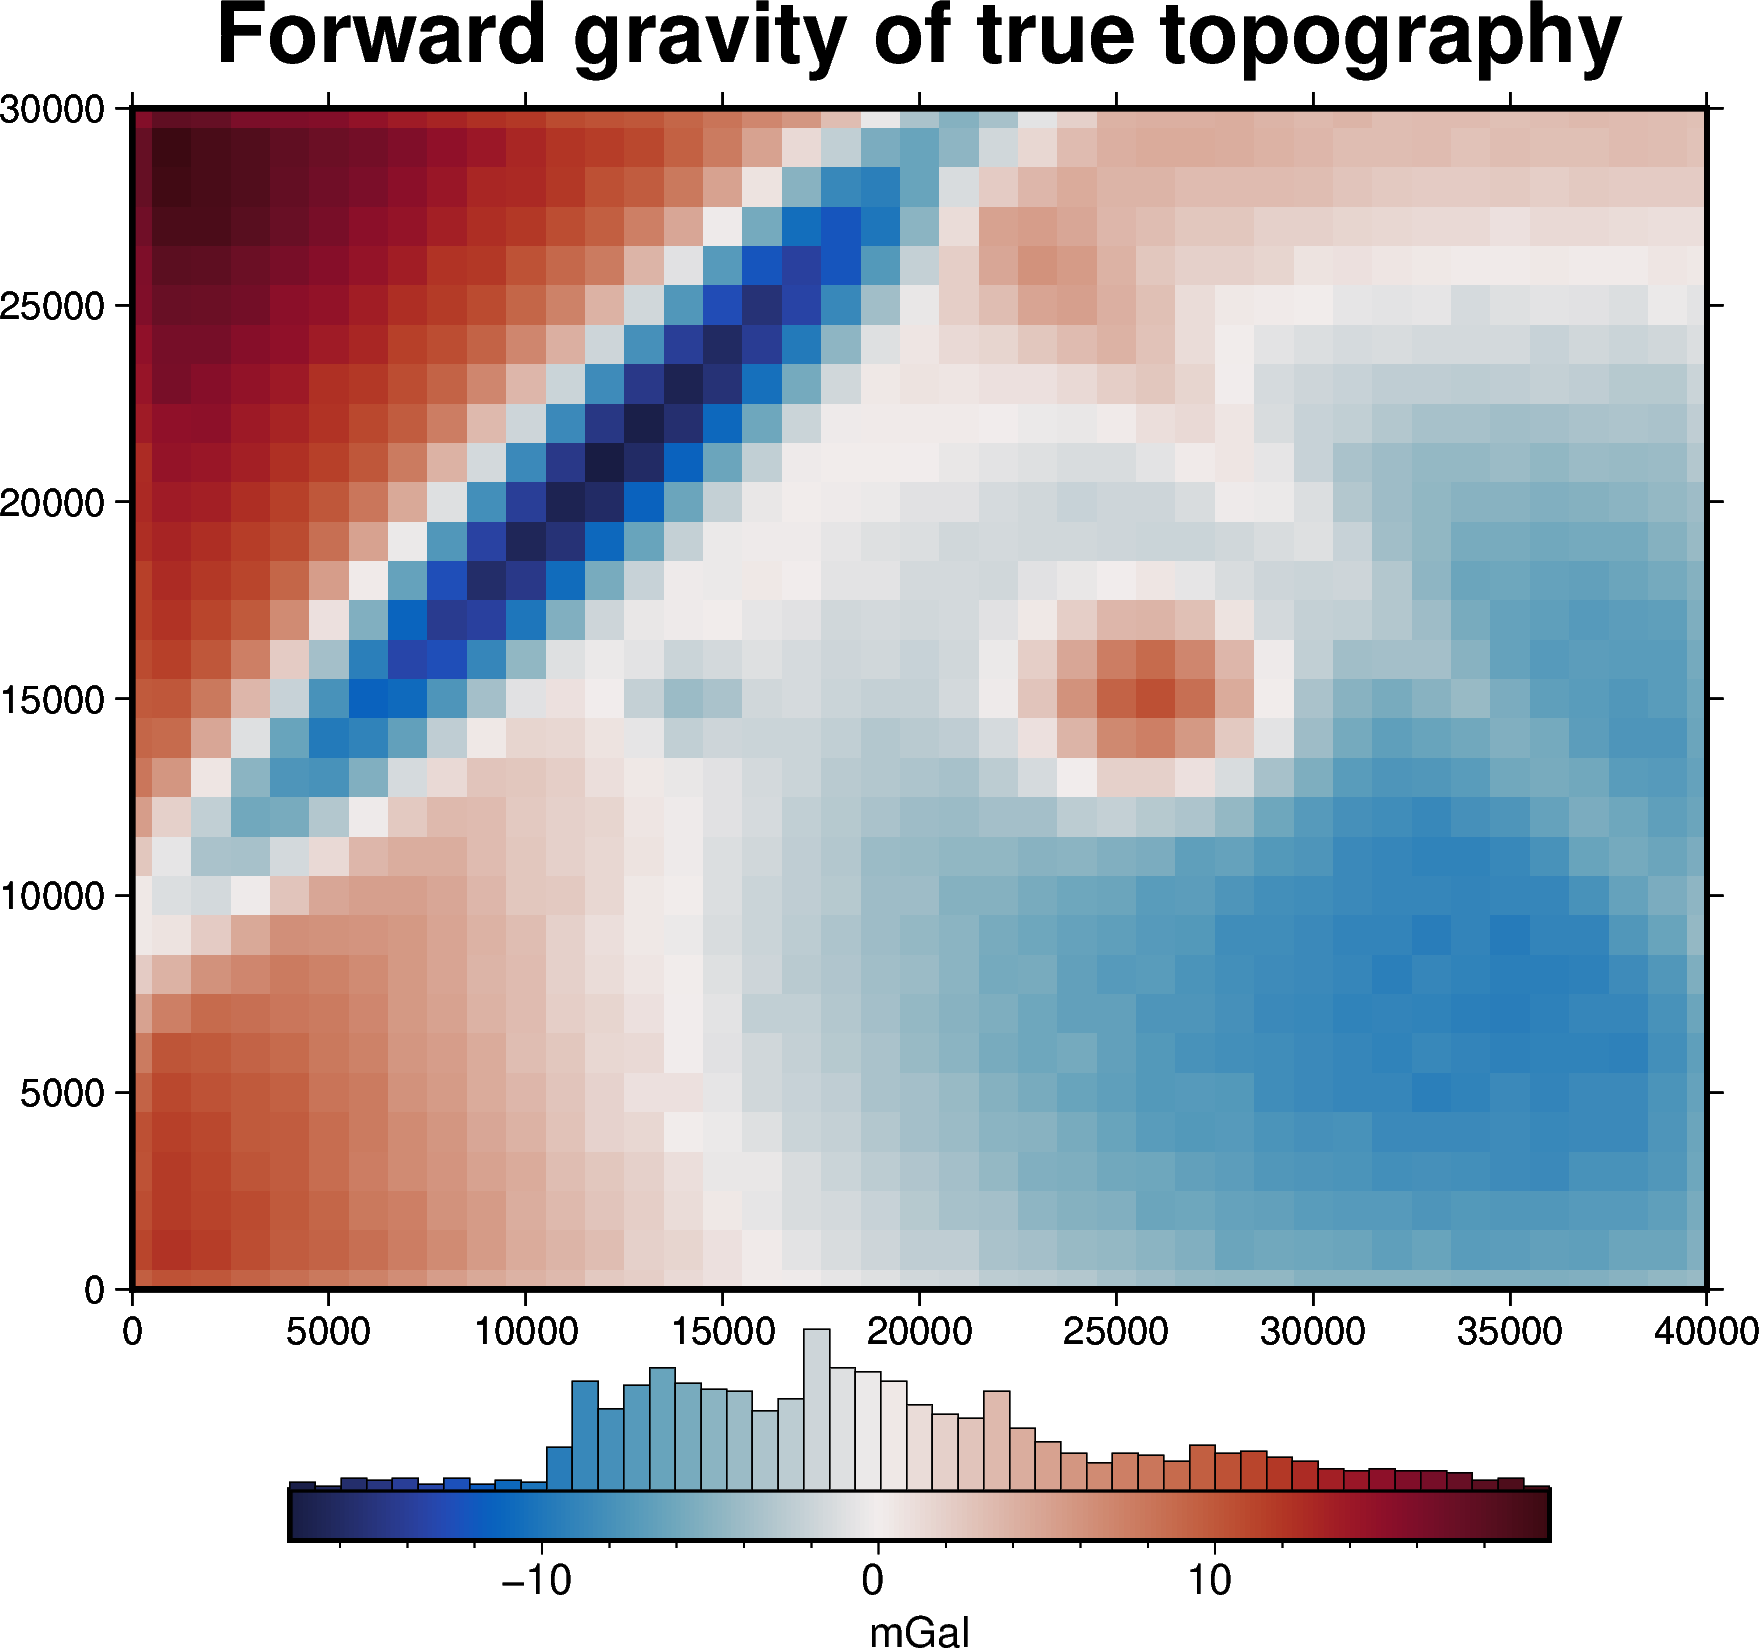

mean of true topography: 492.2704164812973 m 


In [2]:
# the density contrast is between rock (~2670 kg/m3) and air (~1 kg/m3)
true_density_contrast = 2670 - 1
(
    true_topography,
    _,
    constraint_points,
    observed_gravity,
) = invert4geom.load_synthetic_model(
    spacing=1000,
    region=(0, 40000, 0, 30000),
    number_of_constraints=10,
    density_contrast=true_density_contrast,
    gravity_noise=0.2,
    plot_topography_diff=False,
)

true_zref = true_topography.values.mean()
print(f"mean of true topography: {true_zref} m ")

For simplicity here we assume that we know reference level `zref` of the true topography, and use this when creating our starting model.

What we don't know in this scenario is what value to use for the `density contrast`. We will use an optimization of a range of density values to find the one which is optimal.

Each `density contrast` value will give a score, and the lowest score will show which `density contrast` value is optimal. 

The score is calculated as the root mean square error between the points of known topography (`constraints`) and the inverted topography at those points. 

## Get a score

First we need to use the `density contrast` value to create the flat starting model. We will then use this in an inversion to calculate a `score`.


In [3]:
data = invert4geom.create_data(observed_gravity)

# make a flat grid at the height of the zref
grid_coords = vd.grid_coordinates(region=data.region, spacing=data.spacing)
starting_topography = vd.make_xarray_grid(
    grid_coords, data=np.ones_like(grid_coords[0]) * true_zref, data_names="upward"
)

model = invert4geom.create_model(
    zref=true_zref,
    density_contrast=2300,  # compared to true value of 2669
    topography=starting_topography,
)

In [4]:
data.inv.forward_gravity(
    model,
    progressbar=True,
)

  0%|          | 0/1271 [00:00<?, ?it/s]

In many cases, we want to remove a regional signal from the misfit to isolate the residual signal. In this simple case, we assume there is no regional misfit and set it to 0

In [5]:
data.inv.regional_separation(
    method="constant",
    constant=0,
)

makecpt [ERROR]: Option T: min >= max


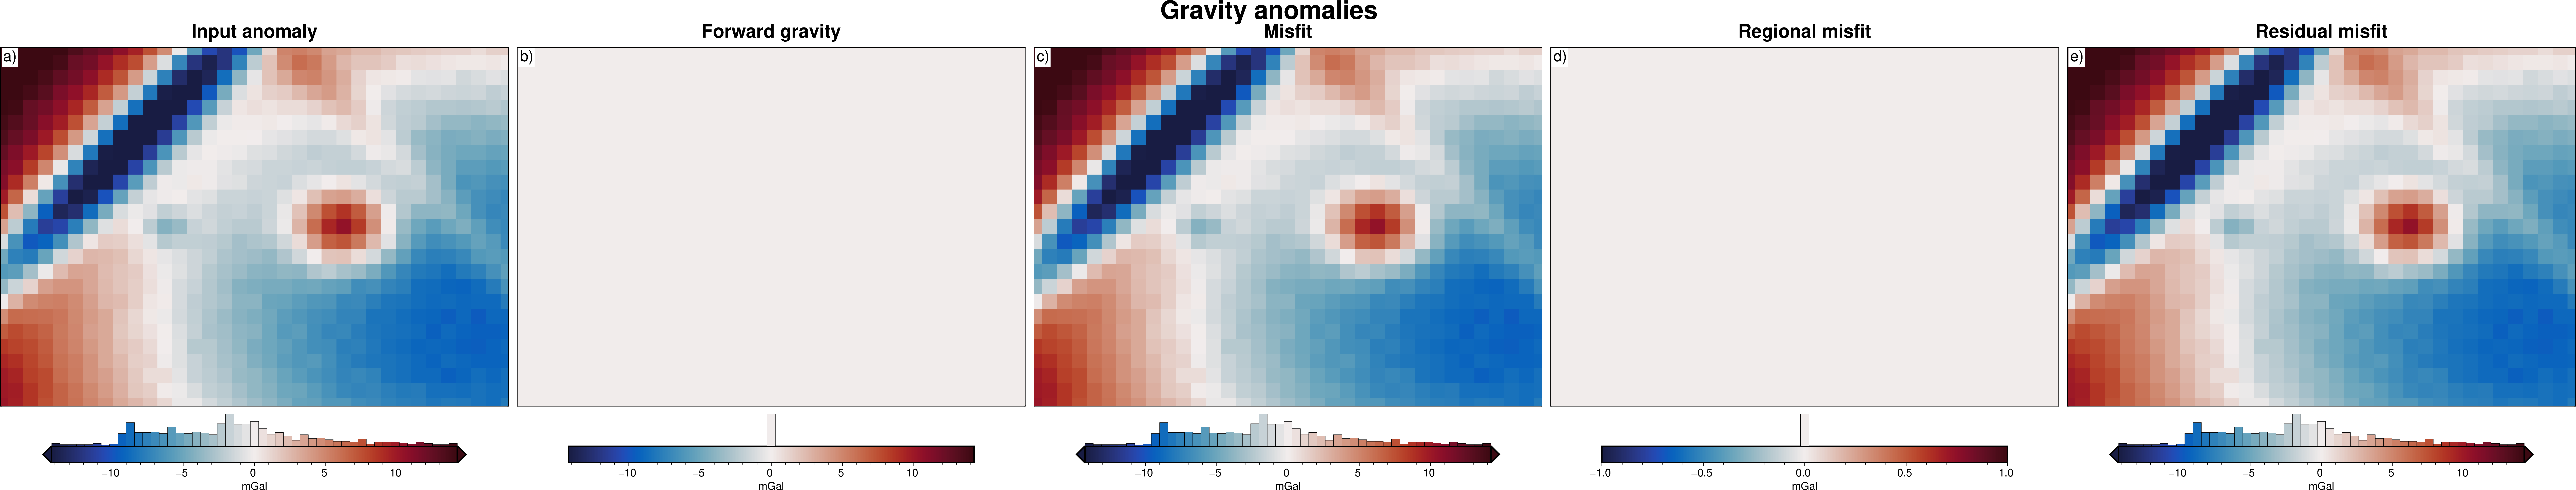

In [6]:
data.inv.plot_anomalies()

In [7]:
# setup the inversion
inv = invert4geom.Inversion(
    data,
    model,
    solver_damping=0.1,
    # set stopping criteria
    max_iterations=30,
    l2_norm_tolerance=0.45,
    delta_l2_norm_tolerance=1.005,
)

In [8]:
# run inversion, calculate the score
constraints_optimization_object = inv.constraints_score(
    constraints_df=constraint_points
)
inv.constraints_best_score

np.float64(11.670434031129455)

## Optimization
Lets see if we can improve the score with other values for the density contrast. For each density contrast value we need to recreate the starting prism model, forward calculate its starting gravity, and recalculate the gravity misfit, including the regional and residual components. Then we can re-run the inversion.

This is a classic optimization problem, where we vary the density contrast to find which value produces the best score. For this we use the Python package [Optuna](https://optuna.readthedocs.io/en/stable/index.html). 

For each trial a `.pickle` file containing the inversion results will be created. Once all trials are complete, all but the best trial's pickle files will be deleted. Additionally, another `.pickle` file will be created containing the Optuna study object with all the trial information and results.

By default, [optimize_inversion_zref_density_contrast](../api/generated/invert4geom.Inversion.optimize_inversion_zref_density_contrast.rst) will use a sampler to choose density contrast values between the provided `density_contrast_limits` and repeat this `n_trials` times. This may skip large portions of the parameter space. If instead you would like to systematically test density contrast values at a constant interval, you can set `grid_search` to True, and this will test all damping values as defined by:

```python
np.linspace(<<lower density contrast limit>>, <<upper density contrast limit>>, n_trials)
```

In [9]:
density_optimization_obj = inv.optimize_inversion_zref_density_contrast(
    constraints_df=constraint_points,
    density_contrast_limits=(2400, 3000),
    n_trials=10,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    starting_topography_kwargs={
        "method": "flat",
        "region": inv.model.region,
        "spacing": inv.model.spacing,
    },
    # grid_search=True,
    plot_scores=False,
    fname="../tmp/05_density_contrast_optimization",
    fold_progressbar=True,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


In [10]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/05_density_contrast_optimization_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/05_density_contrast_optimization.pickle").open("rb") as f:
    inv_results = pickle.load(f)

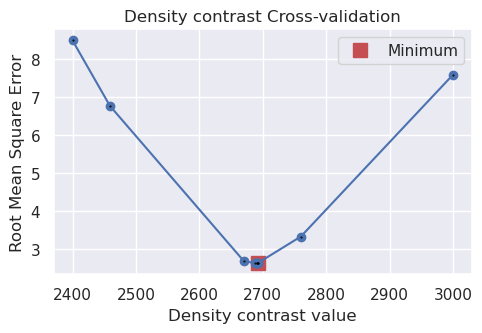

In [11]:
fig = invert4geom.plot_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density contrast",
    logx=False,
    logy=False,
)

Lets see how the optimization perform by comparing the estimated `best` density value to the true density value used to calculate the observed gravity

In [12]:
print(
    f"True density contrast: {true_density_contrast}, "
    f"best density contrast from optimization: {inv_results.model.density_contrast}"
)

True density contrast: 2669, best density contrast from optimization: 2692


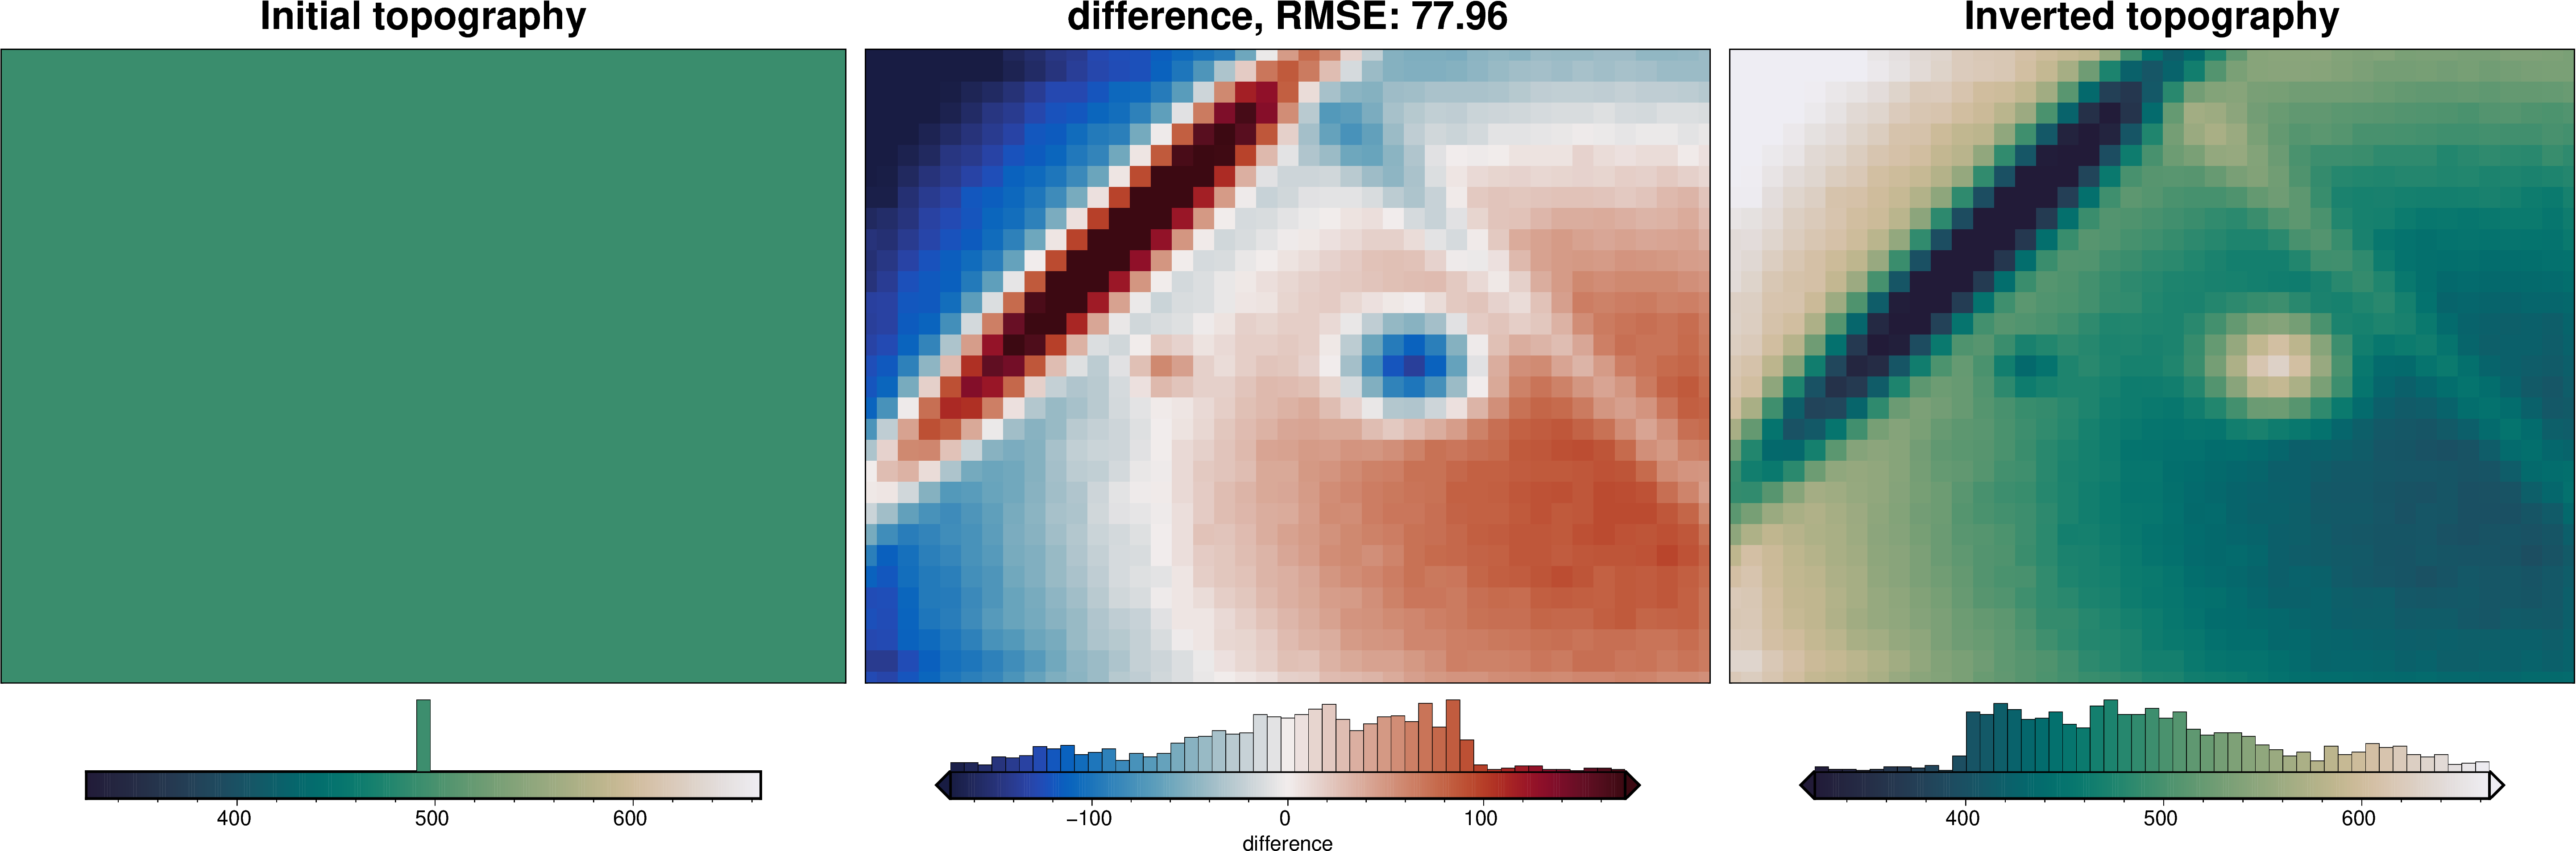

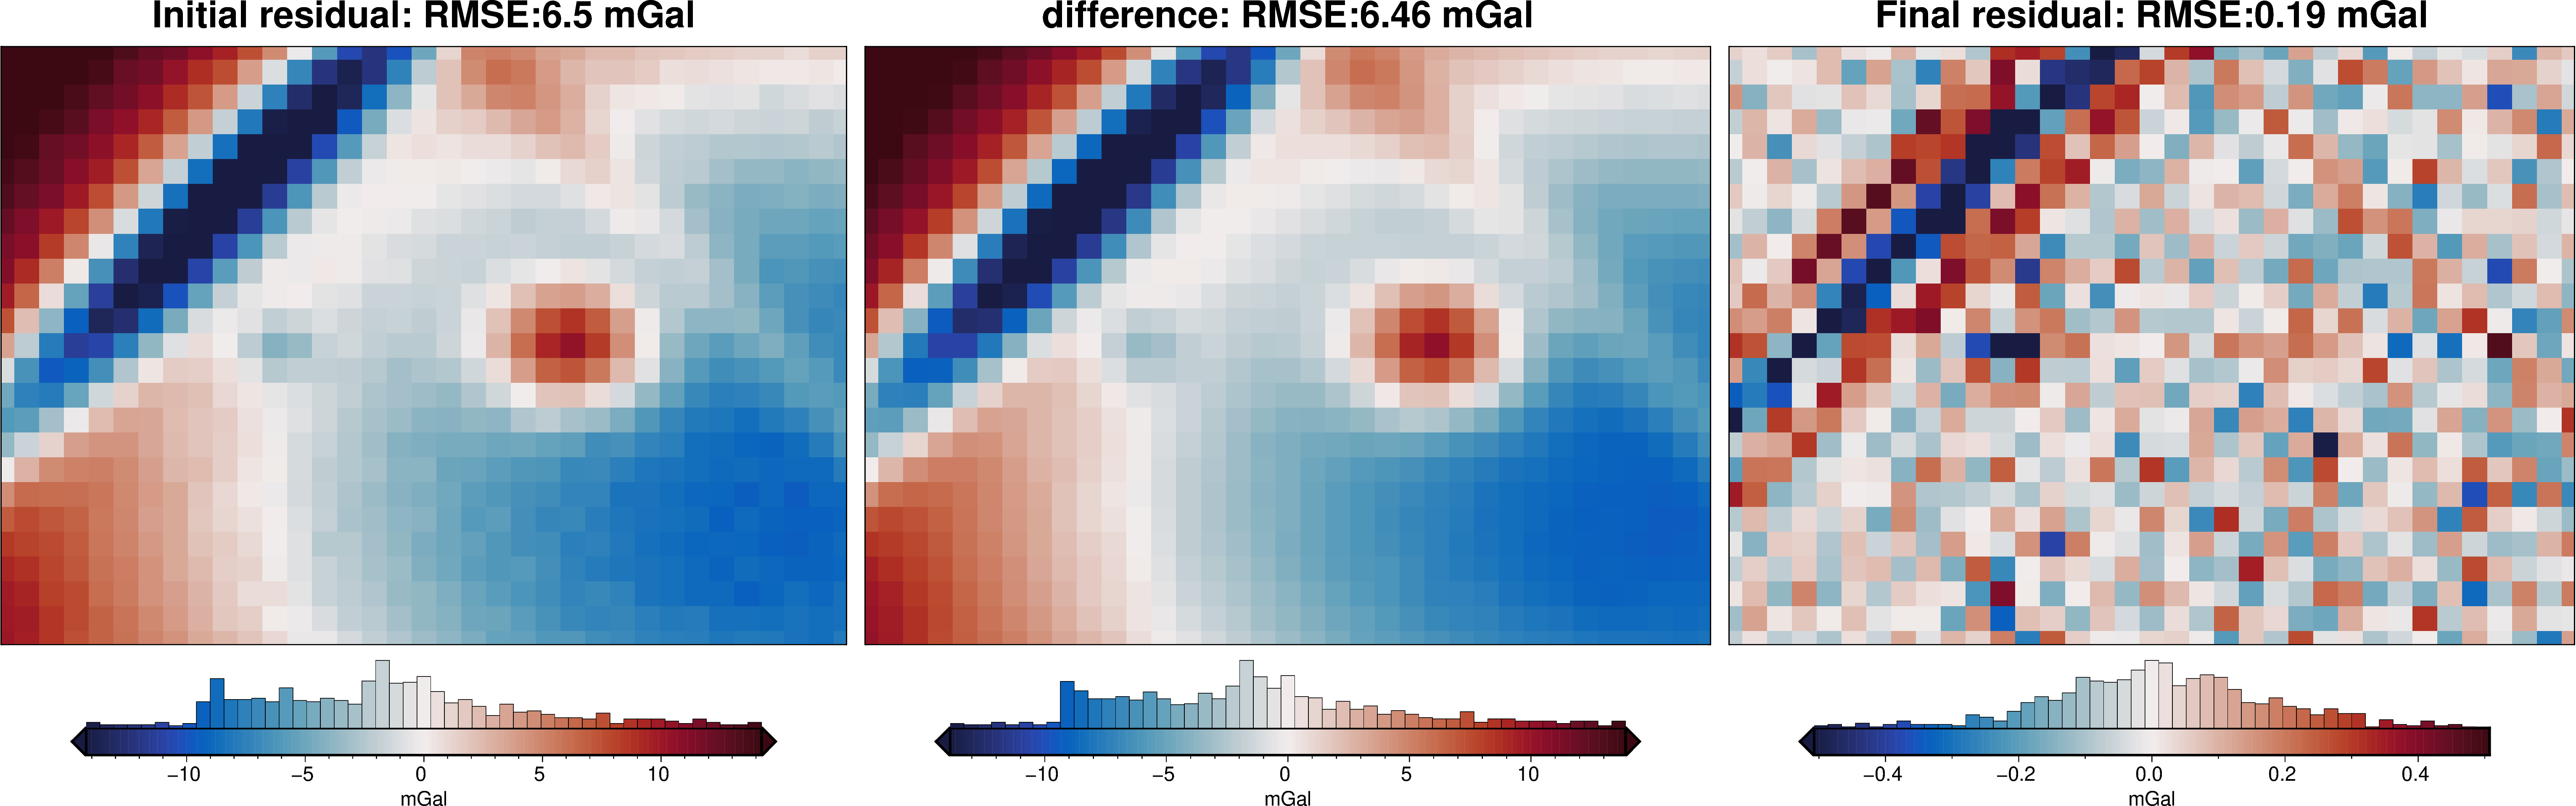

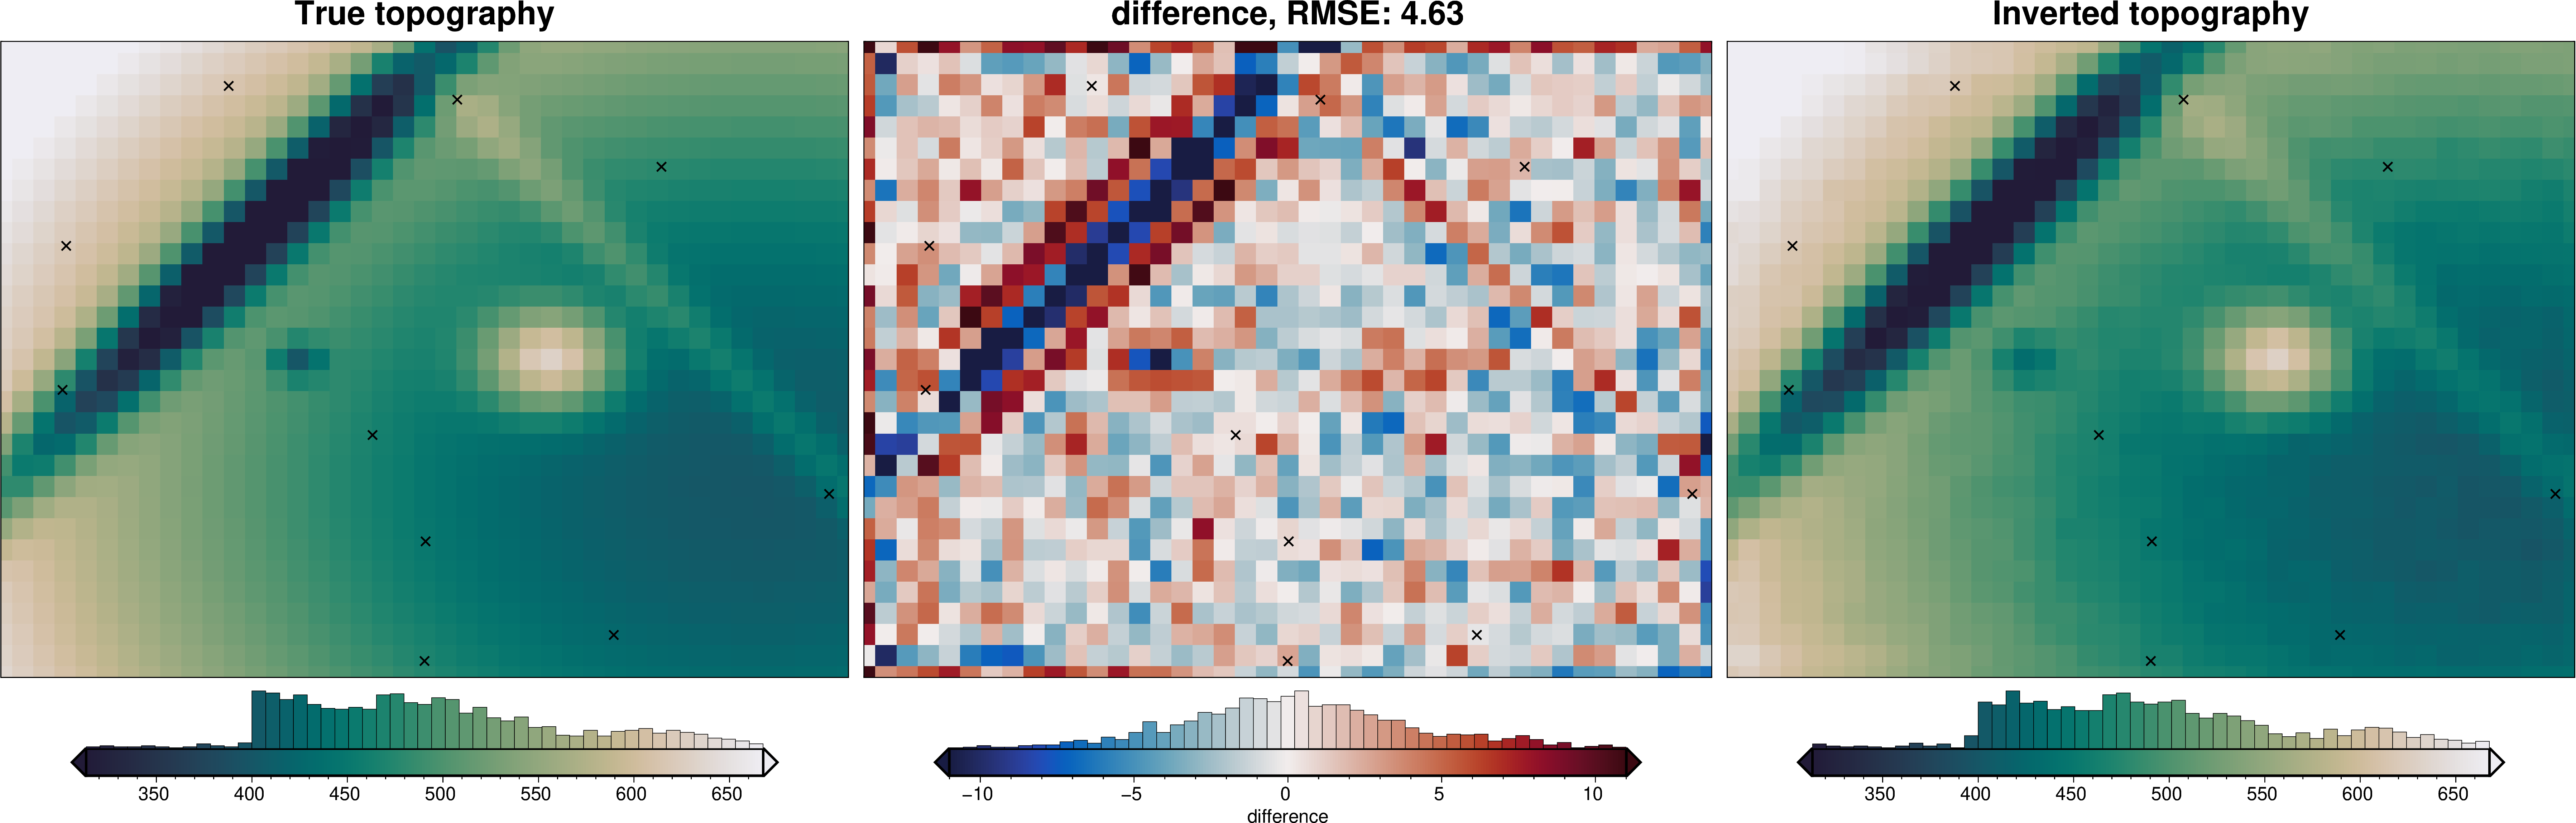

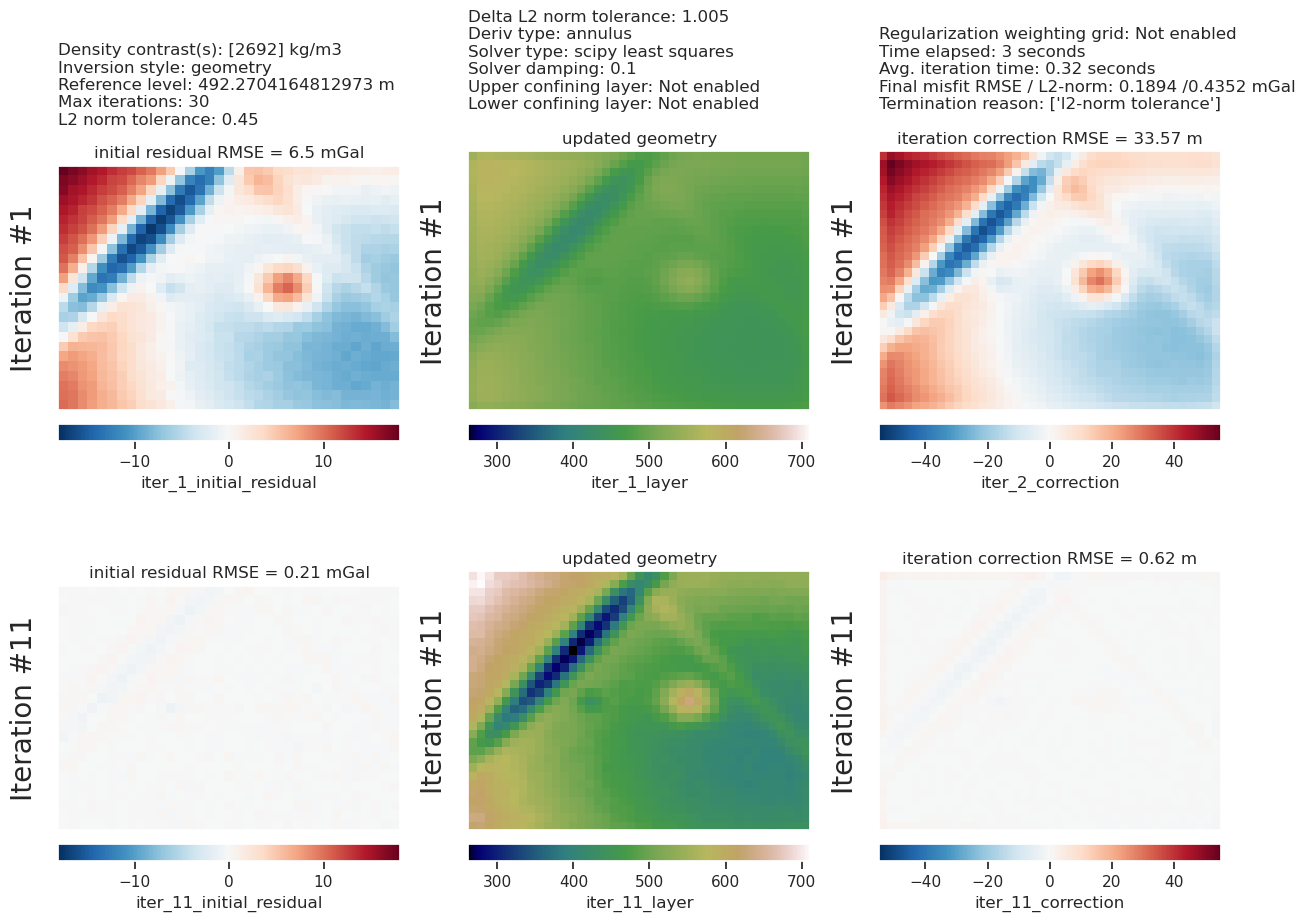

In [13]:
inv_results.plot_inversion_results(iters_to_plot=2)

_ = ptk.grid_compare(
    true_topography,
    inv_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

## Run inversion with poor choice of density contrast

In [14]:
# set a bad reference level
bad_density_contrast = 4000

bad_density_contrast_results = invert4geom.run_inversion_workflow(
    grav_ds=data,
    calculate_starting_gravity=True,
    calculate_regional_misfit=True,
    density_contrast=bad_density_contrast,
    zref=true_zref,
    fname="../tmp/05_bad_density_contrast",
    starting_topography_kwargs={
        "method": "flat",
        "upwards": true_zref,
        "region": data.region,
        "spacing": data.spacing,
    },
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    inversion_kwargs={
        "max_iterations": 30,
        "l2_norm_tolerance": 0.45,
        "delta_l2_norm_tolerance": 1.005,
        "solver_damping": 0.1,
    },
)

'forward_gravity' already a variable of `grav_ds`, but is being overwritten since calculate_starting_gravity is True


'reg' already a column of `grav_df`, but is being overwritten since calculate_regional_misfit is True


Iteration:   3%|3         | 1/30 [00:00<?, ?it/s]

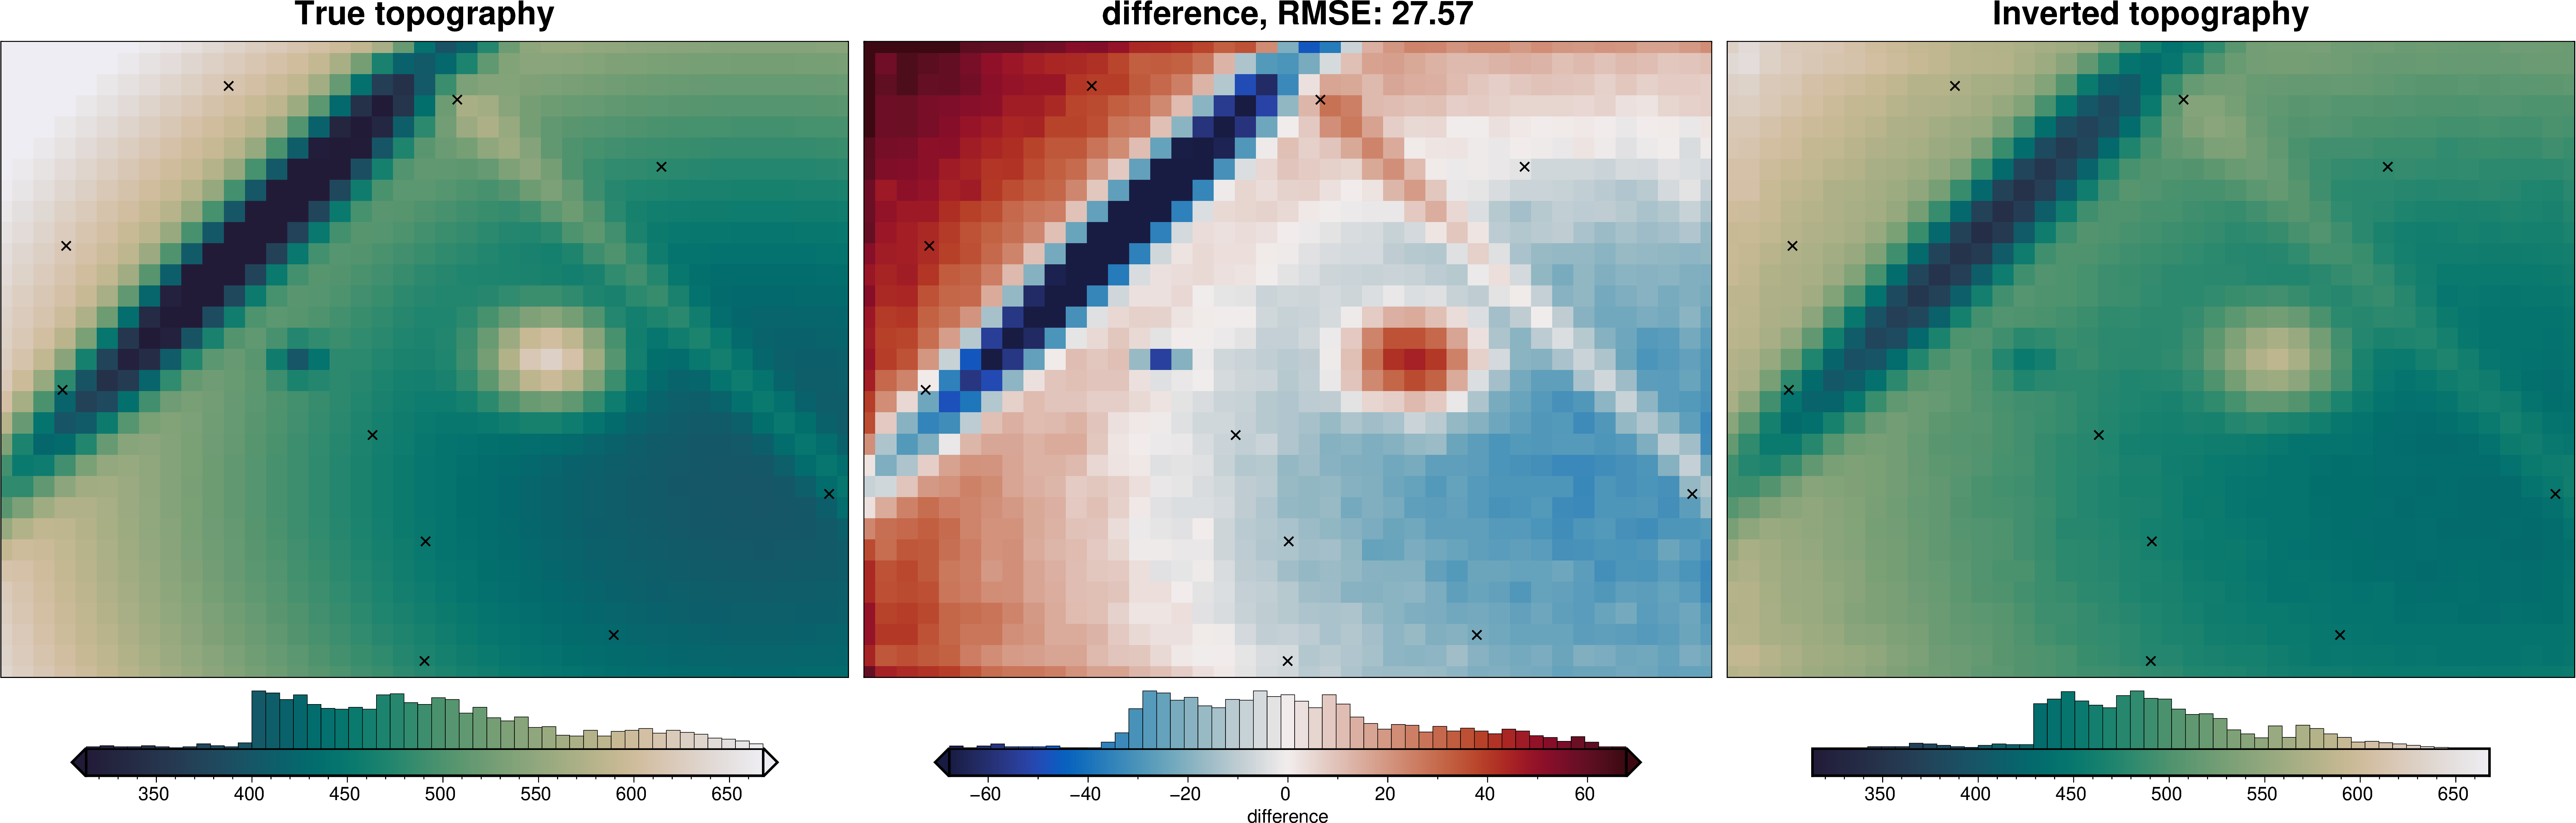

In [15]:
_ = ptk.grid_compare(
    true_topography,
    bad_density_contrast_results.model.topography,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    title="difference",
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

This inversion with a density contrast (4000) instead of the optimal density contrast of ~2670, shows that too high of a density contrast will result in a subdued topography, even though the misfit is minimized equally well. This depicts the non-uniqueness of this style of gravity inversion.